### Classes review, and a toy robot  -- 20220708 CJH
* Make a motor, and encoder and a robot
* drive the (fake) robot
* realize this is pretty much how it works for the FRC robot
  * but with a lot more infrastructure
  * a cool CommandScheduler to handle all the separate activities for us

In [128]:
import time

In [129]:
import keyboard

In [130]:
# if you don't have it
# !pip install keyboard

In [131]:
# play with the keyboard module for a sec - careful not to type all over stuff
# more appropriate in a console than in jupyter cells
start_time = time.time()
while time.time() - start_time < 10:
    key = keyboard.read_key()
    print(f'Last key pressed:{key}         ', end='\r')
    time.sleep(0.1)
print(f'\nDone')

Last key pressed:left          
Done


In [133]:
### make a class for a motor
class Motor:
    
    def __init__(self, output_channel=1):
        self.output_channel = output_channel  # channel for communicating OUT to the (imaginary) hardware
        self.output = 0  # variable from -1 to 1 for % output
    
    def set_power(self, power):
        self.output = power
        # do something to the hardware channel to update the motor output
        
    def get_power(self):
        return self.output

In [134]:
# make a class for an encoder 
class Encoder:
    
    def __init__(self, input_channels=(2,3), motor=None):
        self.input_channels = input_channels # channel for communicating IN from the (imaginary) hardware
        self.motor = motor  # cheat for this simple example
        
        self.counts = 0  # variable from -1 to 1 for % output
        self.distance_per_pulse  = 1/128  # quiz: is this an integer or a float?
        self.rate = 0
        self.previous_counts = 0
        self.previous_time = 0
    
    def get_counts(self):
        return self.counts
        
    def get_distance(self):
        return self.counts * self.distance_per_pulse
    
    def get_rate(self):
        return self.rate
        
    def update(self):
        # normally you would be just asking the hardware for this, but here's we're faking it
        now = time.time()
        self.counts += self.motor.get_power()  # just a toy example
        self.rate = (self.counts - self.previous_counts) * self.distance_per_pulse / (now - self.previous_time)
        self.previous_time = now
        self.previous_counts = self.counts
        

In [143]:
# make a robot class
# note the structure of the while statement
class Robot:
   
    def __init__(self, motor=None, encoder=None):
        self.motor = motor
        self.encoder = encoder
        self.loop_time = 0.02
        
    def run(self):
        print(f'Starting robot!')
        start_time = time.time()
        loop_counter = 0
        
        # while True:  this version runs forever, so may not be a good idea
        while loop_counter < 1000:
         
            # check our inputs - in this case a keyboard instead of a joystick
            if keyboard.is_pressed('q'):
                break  # done with the while loop
            elif keyboard.is_pressed(']'):
                new_power = min(1, self.motor.get_power() + .05 )
                self.motor.set_power(new_power)
            elif keyboard.is_pressed('['):
                new_power = max(-1, self.motor.get_power() - .05 )
                self.motor.set_power(new_power)
            else:
                pass  # just for teaching purposes
            
            self.encoder.update()
            
            message = f'Time: {time.time()-start_time: 2.1f}  Robot distance: {self.encoder.get_distance(): 2.2f}  '
            message += f'Rate:{self.encoder.get_rate(): 2.2f}  Motor output: {self.motor.get_power():+2.2f}     '
            print(message, end='\r')
            
            time.sleep(self.loop_time)
            loop_counter += 1
        
        end_time = time.time()
        print(f'\nDisabling robot after {end_time - start_time:2.2f} s')
        

#### now make a robot
* instantiate a motor and an encoder
* instantiate a robot with your motor and encoder

In [144]:
my_motor = Motor(1)
my_encoder = Encoder((6,7), my_motor)

In [145]:
my_robot = Robot(motor=my_motor, encoder=my_encoder)

#### run your robot
* don't start typing in the next cell - hit escape if you need to
* mapped q to quit, [ to slow down and ] to speed up

In [146]:
my_robot.run()

Starting robot!
Time:  31.3  Robot distance:  0.71  Rate: 0.00  Motor output: -0.00     
Disabling robot after 31.37 s


#### that's kind of how the classes work in the robots we use
* the classes for the components probably inherit from parent classes
  * e.g. basic PWM, basic digital IO, basic analog voltage, basic human input 

---
### let's add some telemetry

In [161]:
import numpy as np
import matplotlib.pyplot as plt

In [162]:
# now with an extra set of data
class Robot:
   
    def __init__(self, motor=None, encoder=None):
        self.motor = motor
        self.encoder = encoder
        self.loop_time = 0.02
        self.loop_counter = 0
        
        self.data_buffer_length = 1024
        self.data = None
   
    def reset_data(self):
        self.data = {'TIME':np.zeros(self.data_buffer_length), 'DISTANCE':np.zeros(self.data_buffer_length), 'RATE':np.zeros(self.data_buffer_length)}
        
    def run(self):
        print(f'Starting robot!')
        start_time = time.time()
        self.loop_counter = 0
        self.reset_data()
        
        # while True:  this version runs forever, so may not be a good idea
        while self.loop_counter < 1000:
         
            # check our inputs - in this case a keyboard instead of a joystick
            if keyboard.is_pressed('q'):
                break  # done with the while loop
            elif keyboard.is_pressed(']'):
                new_power = min(1, self.motor.get_power() + .05 )
                self.motor.set_power(new_power)
            elif keyboard.is_pressed('['):
                new_power = max(-1, self.motor.get_power() - .05 )
                self.motor.set_power(new_power)
            else:
                pass  # just for teaching purposes
            
            self.encoder.update()
            
            # write data - should protect this so we 
            self.data['TIME'][self.loop_counter] = time.time() - start_time
            self.data['DISTANCE'][self.loop_counter] = self.encoder.get_distance()
            self.data['RATE'][self.loop_counter] = self.encoder.get_rate()
            
            message = f'Time: {time.time()-start_time: 2.1f}  Robot distance: {self.encoder.get_distance(): 2.2f}  '
            message += f'Rate:{self.encoder.get_rate(): 2.2f}  Motor output: {self.motor.get_power():+2.2f}     '
            print(message, end='\r')
            
            time.sleep(self.loop_time)
            self.loop_counter += 1
        
        end_time = time.time()
        print(f'\nDisabling robot after {end_time - start_time:2.2f} s')
        

In [158]:
my_robot = Robot(motor=my_motor, encoder=my_encoder)
my_robot.run()

Starting robot!
Time:  31.1  Robot distance:  0.64  Rate: 0.24  Motor output: +0.95     
Disabling robot after 31.17 s


In [159]:
my_robot.loop_counter

1000

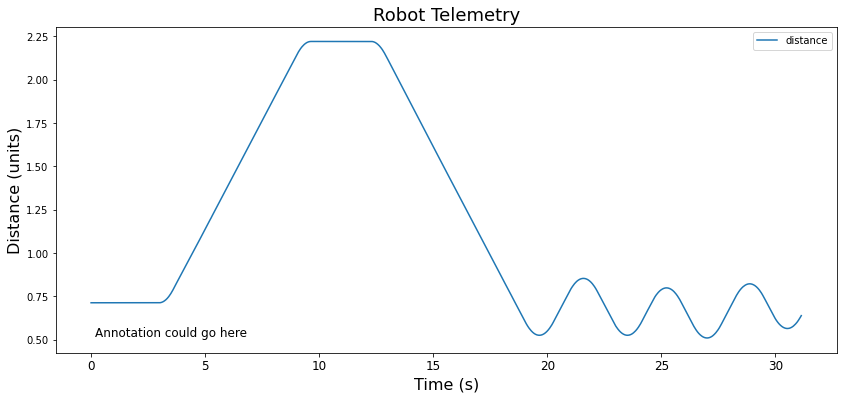

In [184]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
fontsize = 18
ax.plot(my_robot.data['TIME'][:my_robot.loop_counter], my_robot.data['DISTANCE'][:my_robot.loop_counter], label='distance')
ax.set_title(f'Robot Telemetry', fontsize=fontsize)
ax.annotate(f'Annotation could go here', xy=(1, 1), xytext=(0.05, 0.05), textcoords='axes fraction', fontsize=12)
ax.set_xlabel('Time (s)',  fontsize=fontsize-2)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Distance (units)', fontsize=fontsize-2)
# ax.set_ylim([-1,1])
ax.legend()
plt.show()

### take suggestions from the class if time allows